<center><img src="./images/nup_logo_dark.jpeg" width=300 style="display: inline-block;"></center> 

## ML with Python
### Intro to neural networks and backpropagation

<br />
November 15, 2023

### Import libraries and create dataset

In [1]:
import torch
from torchvision import datasets, transforms

# Loading the MNIST dataset
train_data = datasets.MNIST('data', train=True, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor()
                            ]))
test_data = datasets.MNIST('data', train=False, 
                           transform=transforms.Compose([
                               transforms.ToTensor()
                           ]))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

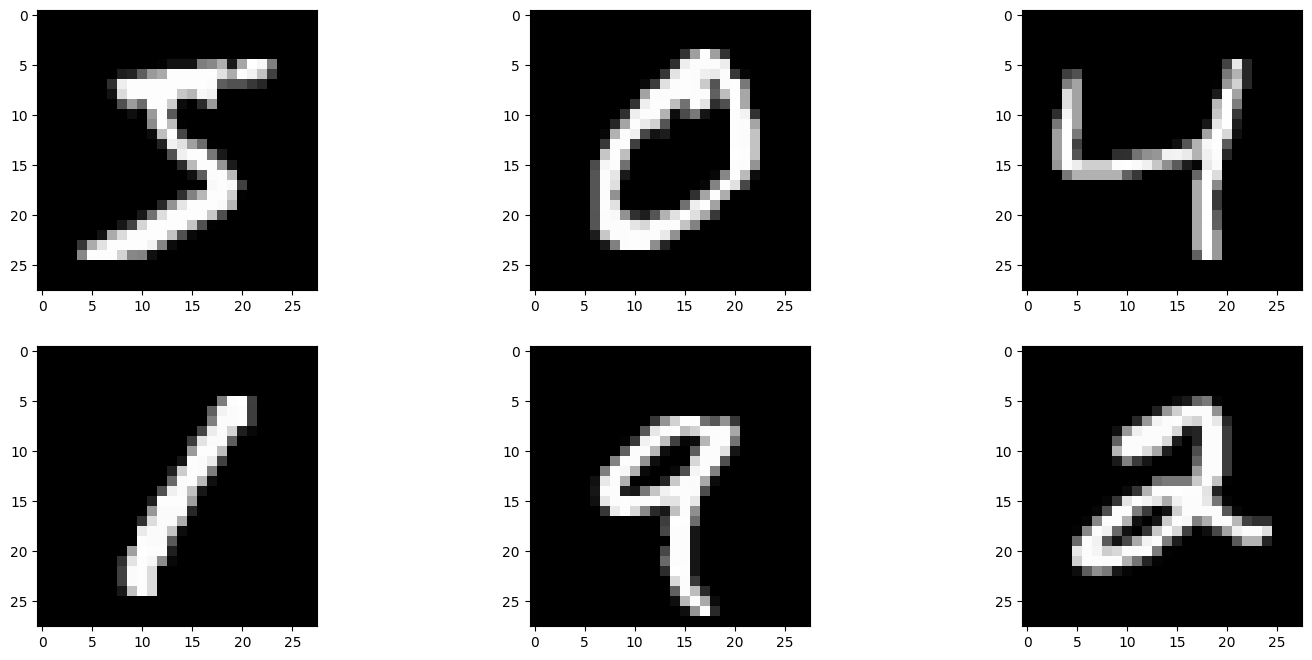

In [2]:
import matplotlib.pyplot as plt
import matplotlib

fig, gs = plt.figure(figsize=(18, 8)), matplotlib.gridspec.GridSpec(2, 3)

first_batch = next(iter(train_loader))
for i in range(6):
    plot = fig.add_subplot(gs[i])
    plot.imshow(first_batch[0][i, 0], cmap='gray') # cmap='gray_r'

plt.show()

In [3]:
len(first_batch), first_batch[0].shape, first_batch[1].shape

(2, torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [4]:
first_batch[0][0, 0, 5]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0118, 0.0706, 0.0706, 0.0706, 0.4941, 0.5333,
        0.6863, 0.1020, 0.6510, 1.0000, 0.9686, 0.4980, 0.0000, 0.0000, 0.0000,
        0.0000])

In [10]:
from torch import nn

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 10),  # assuming input of size 784, modify accordingly
    nn.Softmax(dim=1)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training

In [11]:
for epoch in range(10):  # loop over the dataset multiple times (10 epochs)
    running_loss = 0.0
    for images, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # print average loss per epoch
    print(f"Epoch {epoch + 1}, Loss: {running_loss/len(train_loader)}")

print("Finished Training")

Epoch 1, Loss: 2.284758306121826
Epoch 2, Loss: 2.2443335563659668
Epoch 3, Loss: 2.1956285526275634
Epoch 4, Loss: 2.144700747172038
Epoch 5, Loss: 2.0893583413441976
Epoch 6, Loss: 2.036031748453776
Epoch 7, Loss: 1.98765545241038
Epoch 8, Loss: 1.9478427232106528
Epoch 9, Loss: 1.9157815894444783
Epoch 10, Loss: 1.8898008180618286
Finished Training


# Testing

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d%%' % (100 * correct / total))

Accuracy of the network on test images: 76 %


In [15]:
x_test = next(iter(test_loader))
outputs = model(x_test[0])
_, predicted = torch.max(outputs.data, 1)
predicted

tensor([7, 2, 1, 0, 4, 1, 4, 9, 4, 7, 0, 0, 9, 0, 1, 3, 4, 7, 3, 4, 7, 6, 6, 8,
        4, 0, 7, 4, 0, 1, 3, 1])

In [16]:
from torchsummary import summary

# Assume input size is (1, 28, 28) for MNIST
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
           Softmax-3                   [-1, 10]               0
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


# Micrograd

In [5]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def f(x):
  return 3*x**2 - 4*x + 5

In [7]:
f(2.)

9.0

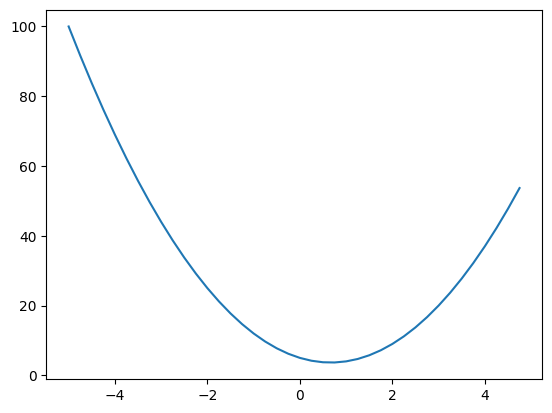

In [8]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [9]:
h = 0.000001
x = 2.
# numerical derivative
(f(x + h) - f(x))/h

8.000003001384925

In [10]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [11]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [12]:
class Value:
  
  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f"Value(data={self.data})"

a = Value(2.)
b = Value(-3.)
a, b

(Value(data=2.0), Value(data=-3.0))

In [13]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self.grad = 0.0
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    return out


In [14]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name=uid + n._op, label=n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [17]:
a = Value(2., label='a')
b = Value(-3., label='b')
c = Value(10., label='c')
d = a*b + c; d.label = 'd'

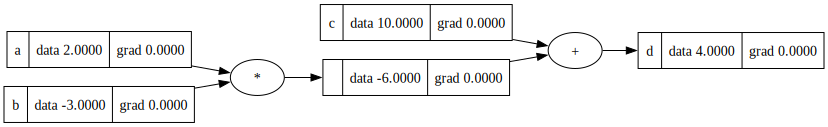

In [18]:
draw_dot(d)

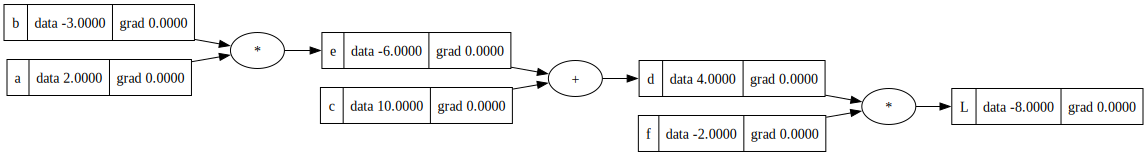

In [20]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

draw_dot(L)

In [25]:
def numerical_derivative():
  h = 0.0001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  # look here:
  d.data += h  
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
numerical_derivative()

-1.9999999999953388


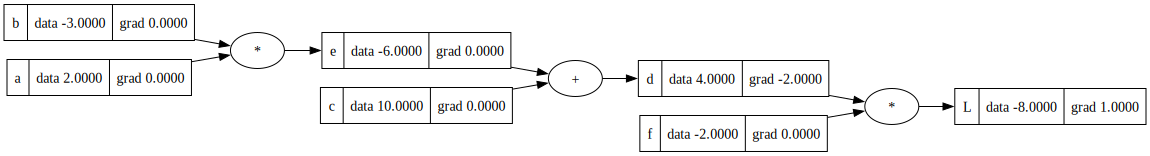

In [26]:
L.grad = 1.
d.grad = -2.
draw_dot(L)

In [19]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self.grad = 0.0
    self._op = _op
    self.label = label
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    
    return out
  
  
  def backward(self):    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


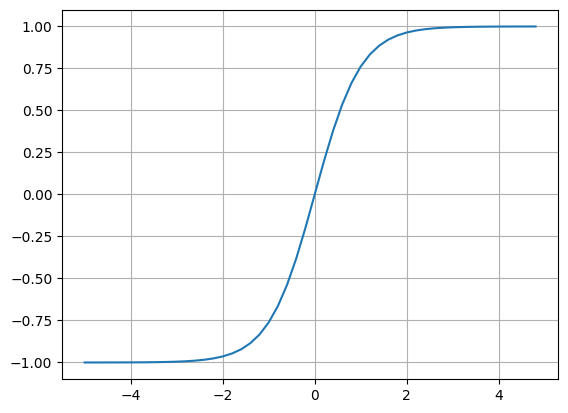

In [27]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

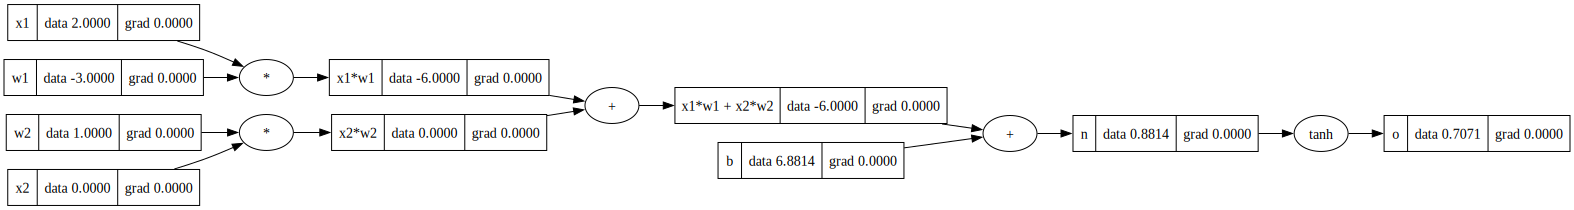

In [36]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

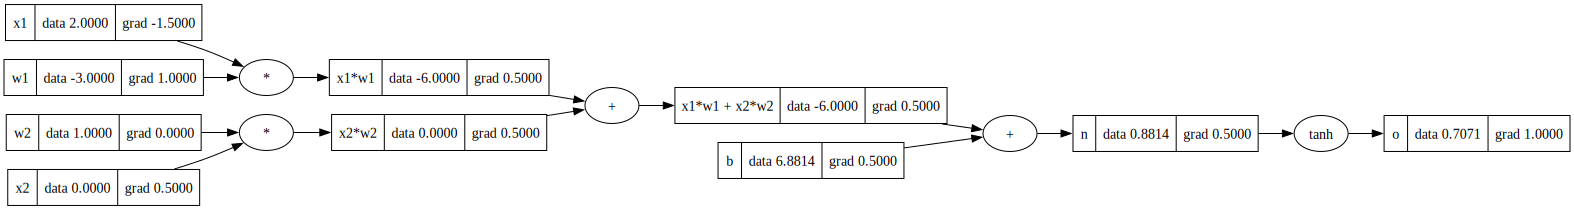

In [37]:
o.backward()
draw_dot(o)

In [39]:
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

topo = []
visited = set()
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

### Roughly the same with PyTorch

In [40]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [41]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [42]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.4051688981177406)

In [43]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [44]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 4.175974635647183
1 2.8244077900334954
2 2.427064689665518
3 0.8534978312120166
4 0.020158506073343532
5 0.01758576218452697
6 0.01555922739320944
7 0.013924216166702095
8 0.012580053813783581
9 0.011458188335045886
10 0.010510159604488029
11 0.009700619866913226
12 0.009003098730177427
13 0.008397332241325942
14 0.007867519716107824
15 0.007401150245167238
16 0.006988190002249121
17 0.0066205046863997575
18 0.006291439378033428
19 0.005995506498863765


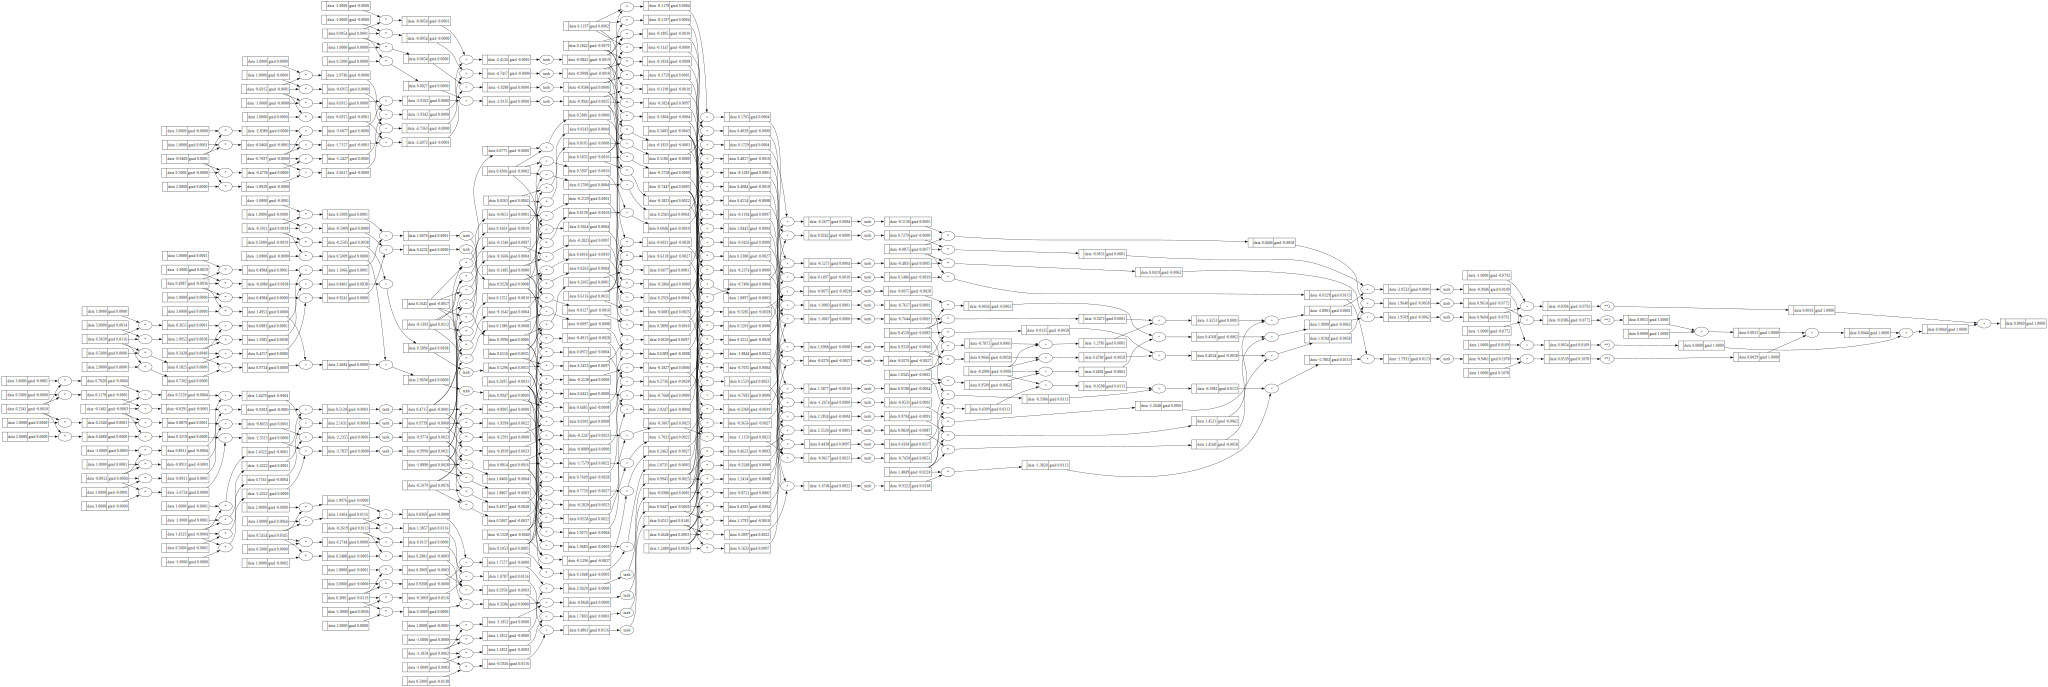

In [46]:
draw_dot(loss)

In [45]:
ypred

[Value(data=0.9613937353550641),
 Value(data=-0.9460879896393412),
 Value(data=-0.9945712202735616),
 Value(data=0.9603883057849962)]